# Exploratory Data Analysis

In [354]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import regex as re
import numpy as np

In [ ]:
raw_df = pd.read_csv('data/raw_case_data.csv', sep=';')

In [ ]:
# Display basic information about the DataFrame
print("Data Overview:")
# print(df.head())  # Display the first few rows
print(raw_df.info())  # Display data types and non-null counts
print(raw_df.describe())  # Display summary statistics

# Check for missing values
print("\nMissing Values:")
print(raw_df.isnull().sum())

# Explore unique values in categorical columns
print("\nUnique Values in Categorical Columns:")
for column in raw_df.select_dtypes(include=['object']).columns:
    print(f"{column}: {raw_df[column].unique()}")

### Pre-processing

In [ ]:
# finding columns that are only missing values and dropping them
nan_mask = raw_df.isnull().sum() == 178378
nan_columns = [raw_df.columns[nan_mask]]
df = raw_df.drop(columns=raw_df.columns[nan_mask], inplace=False)

# saving the processed dataset
df.to_csv("data/case_data.csv", index=False, sep=';')

# changing date columns from string to datetime64
not_date_columns = ['Year of Aircraft Start Ts',
                 'A Aircraft Type',
                 'A Company Iata',
                 'A Data Hash',
                 'A Departure Airport',
                 'A Departure Or Arrival',
                 'A Flight Status',
                 'A Original Stand Id',
                 'A Stand Id',
                 'D Aircraft Type',
                 'D Arrival Airport',
                 'D Company Iata',
                 'D Data Hash',
                 'D Departure Or Arrival',
                 'D Flight Status',
                 'D Original Stand Id',
                 'D Returned To Gate',
                 'D Stand Id',
                 'Id',
                 'Turnaround Id',
                 'Turnaround Type']

date_columns = [col for col in df.columns if col not in not_date_columns]
df[date_columns] = df[date_columns].apply(pd.to_datetime, errors='coerce')

### Some basic viz on the remaining numerical columns

In [ ]:
# Visualize the distribution of numerical features
print("\nDistribution of Numerical Features:")
for column in df.select_dtypes(exclude=['object']).columns:
    plt.figure(figsize=(8, 4))
    sns.histplot(df[column], kde=True)
    plt.title(f'Distribution of {column}')
    plt.show()

In [ ]:
# Visualize relationships between variables
print("\nPairwise Relationships:")
sns.pairplot(df)
plt.show()

## Segment by turnaround type

In [319]:
arrivals = df[df['A Departure Or Arrival'] == 'arrival']
departures = df[df['D Departure Or Arrival'] == 'departure']

In [ ]:
# the size of the dataset doesn't make sense
late_departures = departures[departures['D Scheduled Date Time'] < departures['D Actual Off Block Time']]
late_arrivals = arrivals[arrivals['A Scheduled Date Time'] < arrivals['A Actual In Block Time']]

# Identify rows to filter out
rows_to_filter = late_arrivals.index

# Filter out rows from late_departures_total
filtered_late_departures = late_departures[~late_departures.index.isin(rows_to_filter)]
filtered_late_departures

### Arrivals

### Departures

In [ ]:
departures[departures['D Flight Status'] == 'X']

<Axes: xlabel='D Company Iata'>

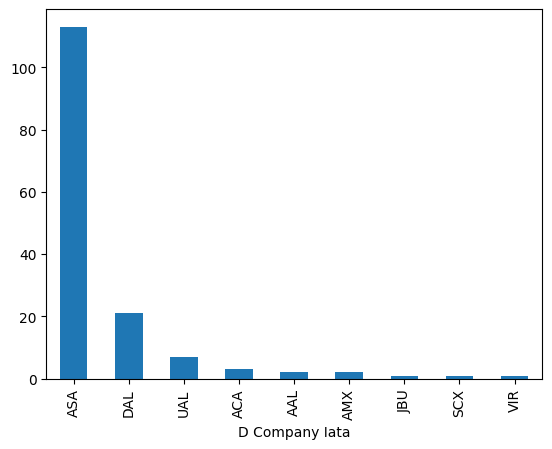

In [171]:
returns = departures[departures['D Returned To Gate'] == True]
returns_freq_by_company = returns['D Company Iata'].value_counts()

returns_freq_by_company.plot(kind='bar')

### Safety issues

In [79]:
no_vest = df[df['Human Without Vest Start Ts'].notnull()]

### Sub-processes (where Assaia shines!)

In [ ]:
sub_proc = df[['Start Ts', 'End Ts', 
               'Highloader Start Ts', 'Highloader End Ts', 
               'Ground Power Start Ts', 'Ground Power End Ts', 
               'Fueling Start Ts', 'Fueling End Ts',
               'Chocks Start Ts', 'Chocks End Ts',
               'Catering Start Ts', 'Catering End Ts',
               'Cargo Start Ts', 'Cargo End Ts',
               'Bridge Start Ts', 'Bridge End Ts', 
               'Tail Stand Start Ts', 'Tail Stand End Ts']]

start_end_columns = sub_proc.columns.tolist()

start_times = []
end_times = []
start_times_pretty = []
end_times_pretty = []

# make column names pretty if there's time
pattern1 = re.compile(r'(.*)(?= Start Ts$)')
pattern2 = re.compile(r'(.*)(?= End Ts$)')

for i, process in enumerate(start_end_columns):
    if i == 0 :
        start_times.append(process)
        start_times_pretty.append(process)
    elif i % 2 == 0:
        start_times.append(process)
        start_times_pretty.append(pattern1.match(process).group(1))
    elif i == 1:
        end_times.append(process)
        end_times_pretty.append(process)
    else:
        end_times.append(process)
        end_times_pretty.append(pattern2.match(process).group(1))


# calculate duration of each sub-process
for start_times, end_times, start_times_pretty, end_times_pretty in zip(start_times, end_times, start_times_pretty, end_times_pretty):
    sub_proc[f'{end_times_pretty}'] = sub_proc[end_times] - sub_proc[start_times]

sub_proc.rename(columns={'End Ts': 'Total'}, inplace=True)

total = sub_proc['Total']
sub_proc = sub_proc.drop(columns=['Total'])
sub_proc.insert(loc=25, column='Total', value=total)

In [ ]:
delta = sub_proc[(sub_proc['Total'] > pd.Timedelta(0)) & (sub_proc['Total'] < pd.Timedelta(days = 1))]

for col in delta.columns.to_list()[-9:]:
    print(delta[col].describe())

In [364]:
# Save the sub-processes and their median duration to a csv
delta_medians = pd.DataFrame(data=delta.iloc[:, -9:].median(), 
                             index=delta.columns.to_list()[-10:])
delta_medians.to_csv("data/sub_processes_delta.csv", 
                     index=True)

### Finding correlations

In [ ]:
# Check common 'Id' values
common_ids = set(df['Id']).intersection(set(late_arrivals['Id']))

# Create boolean masks for common 'Id' values in both DataFrames
df['Late'] = df['Id'].isin(common_ids)
late_arrivals['Late'] = late_arrivals['Id'].isin(common_ids)

# Combine the 'Late' information from both DataFrames
late_df = pd.concat([df, late_arrivals['Late']], axis=1, sort=False)

# Fill NaN values with False in the 'Late' column
late_df['Late'].fillna(False, inplace=True)

In [ ]:
# Convert datetime to Unix timestamp for all datetime columns
for col in date_columns:
    late_df[col] = late_df[col].astype(int) / 10**9

selected_columns = ['D Returned To Gate', 
                    'Late', 
                    'End Ts', 
                    'Highloader End Ts', 
                    'Ground Power End Ts', 
                    'Fueling End Ts',
                    'Chocks End Ts',
                    'Catering End Ts',
                    'Cargo End Ts',
                    'Bridge End Ts', 
                    'Tail Stand End Ts']
selected_df = df[selected_columns]

# Calculate the correlation matrix
correlation_matrix = selected_df.corr()

In [370]:
correlation_matrix.to_csv("data/corr_matrix.csv", index=False)

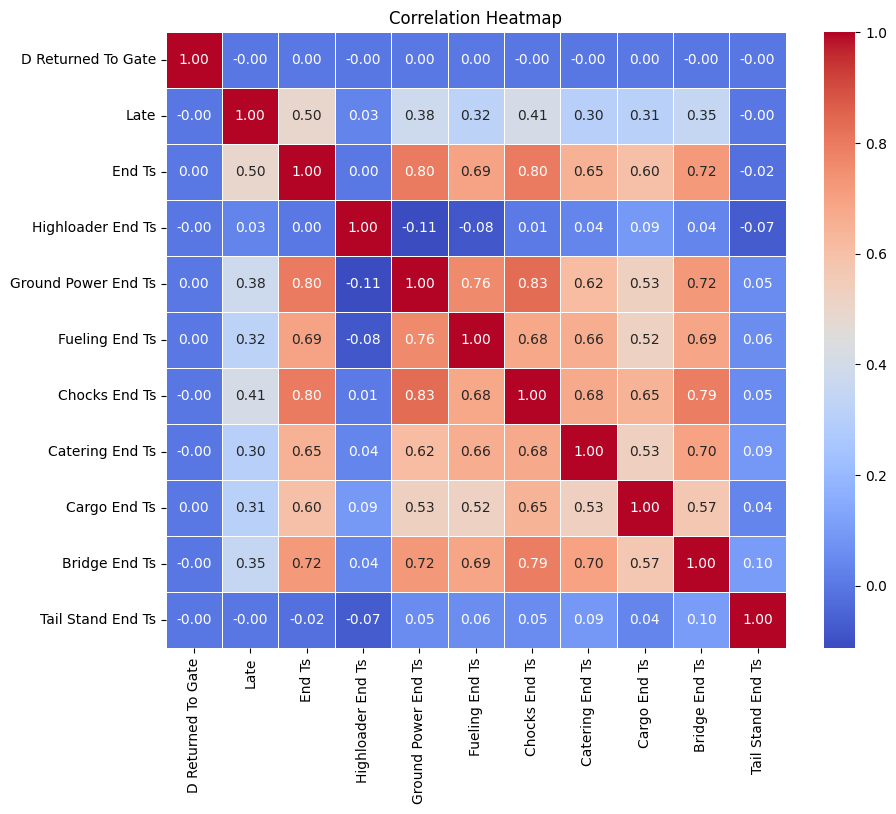

In [369]:
# Create a heatmap using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap')
plt.show()

In [368]:
correlation_matrix.head(2)

,D Returned To Gate,Late,End Ts,Highloader End Ts,Ground Power End Ts,Fueling End Ts,Chocks End Ts,Catering End Ts,Cargo End Ts,Bridge End Ts,Tail Stand End Ts
D Returned To Gate,1.000000,-0.003355,0.000414,-0.004057,0.003914,0.003330,-0.000784,-0.000207,0.001762,-0.002053,-0.002650
Late,-0.003355,1.000000,0.495191,0.032170,0.379363,0.320575,0.405742,0.304136,0.306512,0.349437,-0.003341
